In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

connection = {'host': 'hidden_host',
                      'database':'hidden_database',
                      'user':'hidden_user', 
                      'password':'hidden_password'
                     }


In [2]:
q = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-09-14' and '2022-09-20'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(q, connection=connection)
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


Посмотрим распределение пользователей по группам:

In [3]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


В каждой из групп количество пользователей примерно **равное**. Посмотрим наглядно на распределение целевой метрики каждой группы.

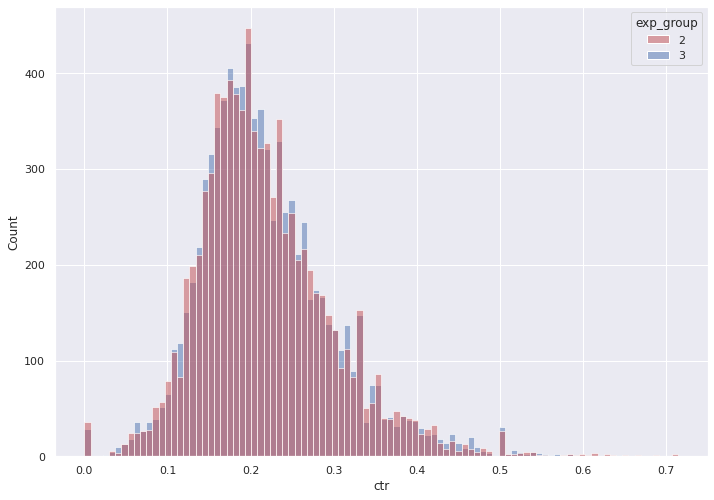

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

In [5]:
stats.ttest_ind(df.query('exp_group == 2').ctr,
                df.query('exp_group == 3').ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

На взгляд группы имеют **одинаковое** распределение `CTR`.

----

Проведем сам тест: Примем за нулевую гипотезу то, что средние наших выборок равны. Сделаем симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации сформируем подвыборки без повторения в 500 юзеров из каждой группы. Запишем полученные p-values в список. Построим гистограмму распределения получившихся 10000 p-values.

In [6]:
number_of_samples = 10000

p_values = [stats.ttest_ind(df.query('exp_group == 2').ctr.sample(500, replace=False),
            df.query('exp_group == 3').ctr.sample(500, replace=False),
            equal_var = False)[1] for i in tqdm(range(number_of_samples))]

100%|██████████| 10000/10000 [01:19<00:00, 125.01it/s]


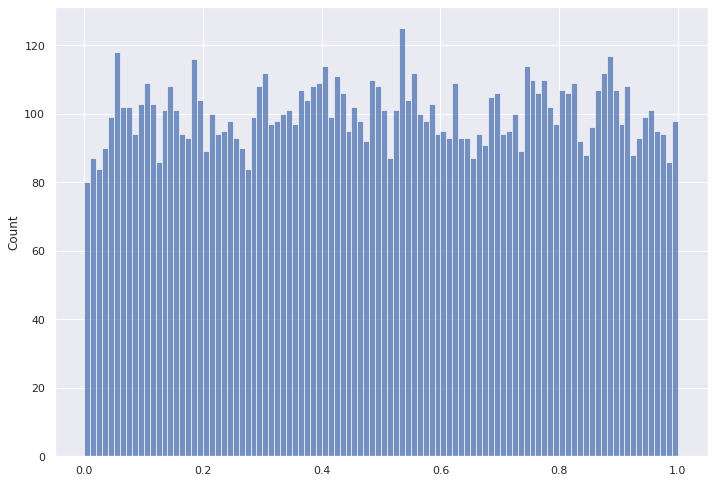

In [7]:
sns.histplot(p_values, bins = 100)
plt.show()

Посчитаем, какой процент p values оказался меньше либо равен 0.05

In [8]:
percent = 0
for i in p_values:
    if (i <= 0.05):
        percent += 1

print('Процент p-values <= 0.05 : {:.2%}'.format(percent/len(p_values)))



Процент p-values <= 0.05 : 4.39%


----

**Вывод:**

- Система сплитования работает корректно, группы получились примерно равные.
- АА-тест прошел успешно, значимые отличия целевой метрики в группах, выявлены лишь в **4.78%** случаев из 10000 симуляций АА-теста.